In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

In [2]:
breast_img = glob.glob('C:/Users/NANDESHVAR/Downloads/Breast_cancer/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

C:/Users/NANDESHVAR/Downloads/Breast_cancer\10253\0\10253_idx5_x1001_y1001_class0.png
C:/Users/NANDESHVAR/Downloads/Breast_cancer\10253\0\10253_idx5_x1001_y1051_class0.png
C:/Users/NANDESHVAR/Downloads/Breast_cancer\10253\0\10253_idx5_x1001_y1101_class0.png


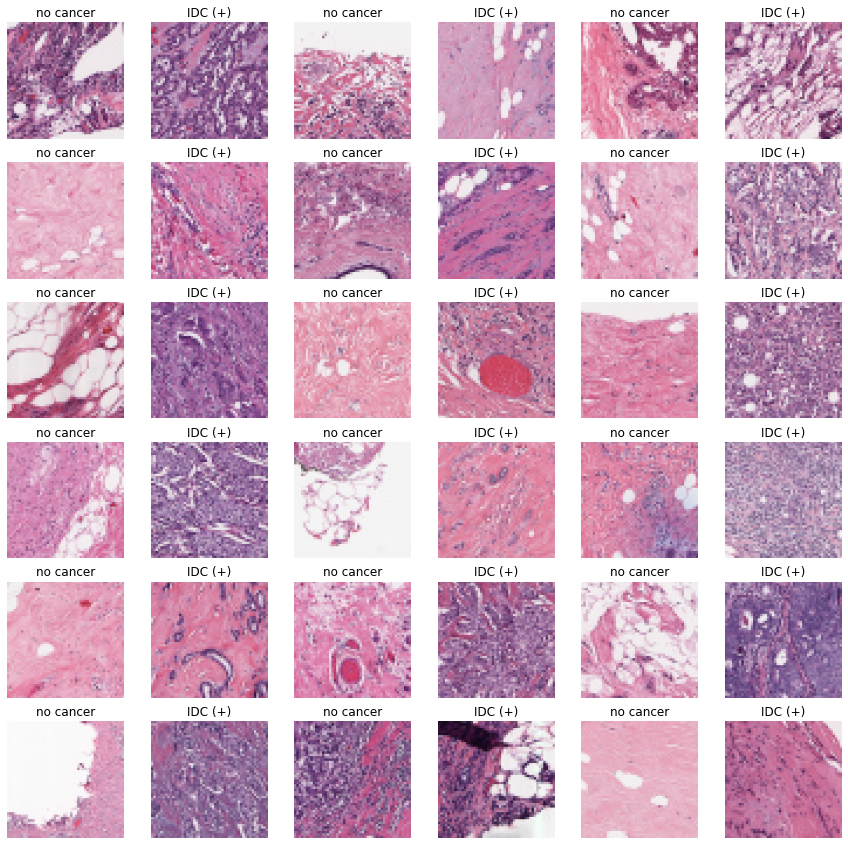

In [3]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [4]:
NewN_IDC=N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
157572


In [6]:
#resizing


non_img_arr = []
can_img_arr = []

for img in NewN_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [7]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

78786
157572
236358


In [8]:
#shuffling
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr[:12389], can_img_arr[:12389]))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 24778
Number of IDC(-) Images: 20987
Number of IDC(+) Images: 3791
Image shape (Width, Height, Channels): (50, 50, 3)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (17344, 50, 50, 3)
Testing Data Shape: (7434, 50, 50, 3)


In [11]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

In [12]:
img_size = (50, 50)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 2 # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
base_model = tf.keras.applications.EfficientNetV2S(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(2, activation= 'softmax')
])

model.summary()

82420632/82420632 [==============================] - 13s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [13]:
model.compile(Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 60, batch_size = 35)

Epoch 1/60
496/496 [==============================] - 1128s 2s/step - loss: 7.0172 - accuracy: 0.7936 - val_loss: 5.8453 - val_accuracy: 0.9001
Epoch 2/60
496/496 [==============================] - 612s 1s/step - loss: 5.0230 - accuracy: 0.8904 - val_loss: 4.2024 - val_accuracy: 0.9144
Epoch 3/60
496/496 [==============================] - 619s 1s/step - loss: 3.6249 - accuracy: 0.9024 - val_loss: 3.0593 - val_accuracy: 0.9185
Epoch 4/60
496/496 [==============================] - 656s 1s/step - loss: 2.6675 - accuracy: 0.9101 - val_loss: 2.2566 - val_accuracy: 0.9256
Epoch 5/60
496/496 [==============================] - 695s 1s/step - loss: 1.9868 - accuracy: 0.9173 - val_loss: 1.6858 - val_accuracy: 0.9313
Epoch 6/60
496/496 [==============================] - 583s 1s/step - loss: 1.5023 - accuracy: 0.9275 - val_loss: 1.3006 - val_accuracy: 0.9345
Epoch 7/60
496/496 [==============================] - 650s 1s/step - loss: 1.1873 - accuracy: 0.9337 - val_loss: 1.0502 - val_accuracy: 0.939

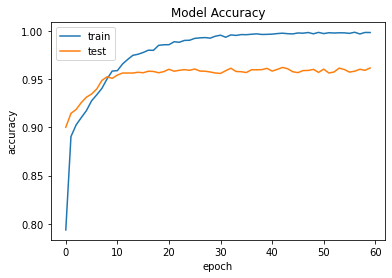

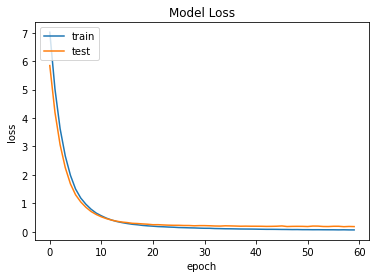

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

233/233 [==============================] - 72s 233ms/step


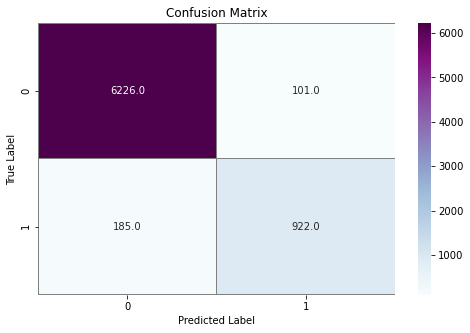

In [15]:
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

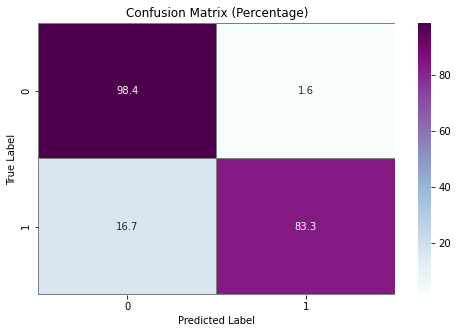

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1) 
Y_true = np.argmax(Y_test, axis=1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

In [17]:
model.evaluate(X_test,Y_test)


233/233 [==============================] - 53s 223ms/step - loss: 0.1831 - accuracy: 0.9615


[0.18313995003700256, 0.9615281224250793]

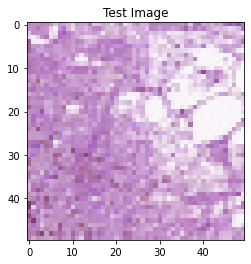

In [18]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
    
index = 1000
img_plot(X_test, index)

In [19]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
index = 4000
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

1/1 [==============================] - 0s 220ms/step
Predicted Value using  cnn model 0
True Value 0
